# **CSCI 566 - Spring 2025 - Homework 1**
# **Problem 1: Kmeans and KNN Algorithms (32 points)**
Adapted from a Kaggle Blog https://www.kaggle.com/code/orkunaran/detailed-eda-k-prototypes-clustering. The 'TODO' blocks will be the blanks to fill. The original data analytics process is very useful and insightful, so we keep most of the analytics even it has less to do with the algorithm implementation.

# Market Customer Personality Analysis

## **Objective**
Customer Personality Analysis is a detailed examination of a company’s ideal customers. It helps businesses understand customer preferences, behaviors, and concerns, allowing them to modify products and marketing strategies accordingly.

By analyzing different customer segments, businesses can allocate resources efficiently, targeting only those segments most likely to buy a specific product rather than marketing to the entire customer base.

---

## **Steps in This Analysis**

### **1. Data Processing (You don't need to do anything)**
- Load and clean the dataset.
- Handle missing values and perform necessary transformations.
- Normalize numerical features and encode categorical variables.

### **2. Clustering Using K-Means Algorithm (You will implement the details of the K-Means Algorithm)**
- Choose an appropriate number of clusters using methods such as the Elbow Method or Silhouette Score.
- Apply the K-Means clustering algorithm to segment customers.
- Analyze the customer groups and their characteristics.

### **3. Clustering Using K-Prototype Algorithm (You don't need to implement the details of the Algorithm, but you need to fulfill some evaluation functions and choose parameters for the algorithm)**
- Combine categorical and numerical data for better clustering.
- Use the K-Prototype algorithm to cluster customers based on both categorical and numerical attributes.
- Compare results with K-Means clustering for better segmentation.

### **4. Classifying Using KNN Algorithm (You will implement the details of the KNN Algorithm)**
- Use the numerical data.
- Choose `Education` as the label to predict.
- Use PCA library to analysis. ATTENTION!! There is a question about the performance of KNN, please remember to reply to that within the same markdown block.

In [2]:
# Connect to google drive and nagivate to the current folder and pip install from requirements.txt
# If you run it locally, you don't need to run this code block
# from google.colab import drive
# drive.mount('/content/drive')

# # Navigate to the folder containing requirements.txt in your Google Drive
# directory_name = "CSCI566-S25-Material/HW1/Part1"
# %cd /content/drive/MyDrive/{directory_name}/

# # Install required packages
# !pip install -r ../requirements.txt

In [3]:
import pandas as pd
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# visuals
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from kmodes.kprototypes import KPrototypes


In [4]:
market = pd.read_csv('marketing_campaign.csv', delimiter="\t")
market = market.drop(['ID','Dt_Customer'], axis=1)

# Descriptive Statistics

In [5]:
market.head(n=10)

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,1957,Graduation,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,1954,Graduation,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,1965,Graduation,Together,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,1984,Graduation,Together,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,1981,PhD,Married,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0
5,1967,Master,Together,62513.0,0,1,16,520,42,98,0,42,14,2,6,4,10,6,0,0,0,0,0,0,3,11,0
6,1971,Graduation,Divorced,55635.0,0,1,34,235,65,164,50,49,27,4,7,3,7,6,0,0,0,0,0,0,3,11,0
7,1985,PhD,Married,33454.0,1,0,32,76,10,56,3,1,23,2,4,0,4,8,0,0,0,0,0,0,3,11,0
8,1974,PhD,Together,30351.0,1,0,19,14,0,24,3,3,2,1,3,0,2,9,0,0,0,0,0,0,3,11,1
9,1950,PhD,Together,5648.0,1,1,68,28,0,6,1,1,13,1,1,0,0,20,1,0,0,0,0,0,3,11,0


In [6]:
market.shape

(2240, 27)

In [7]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year_Birth           2240 non-null   int64  
 1   Education            2240 non-null   object 
 2   Marital_Status       2240 non-null   object 
 3   Income               2216 non-null   float64
 4   Kidhome              2240 non-null   int64  
 5   Teenhome             2240 non-null   int64  
 6   Recency              2240 non-null   int64  
 7   MntWines             2240 non-null   int64  
 8   MntFruits            2240 non-null   int64  
 9   MntMeatProducts      2240 non-null   int64  
 10  MntFishProducts      2240 non-null   int64  
 11  MntSweetProducts     2240 non-null   int64  
 12  MntGoldProds         2240 non-null   int64  
 13  NumDealsPurchases    2240 non-null   int64  
 14  NumWebPurchases      2240 non-null   int64  
 15  NumCatalogPurchases  2240 non-null   i

In [8]:
market.describe()

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


# **Introduction to Data**

## **Dataset Overview**
- The dataset contains **2,240 rows** and **28 columns**.
- Each row represents a unique customer, with **no duplicate entries**.
- No missing values or negative values were found in the dataset.

## **Understanding the Columns**
Some columns require further clarification, such as:
- **AcceptedCmp**
- **Recency**
- **Z_CostContact**
- **Response**

Understanding these columns is essential for accurate analysis.

## **Key Observations**
- **Income Distribution:**
  - The highest income value is **6,666,666**, which appears to be an outlier.
  - Most income values fall between **35k and 68k**.

- **Website Visits:**
  - The **average number of website visits per month** is **5** for **2,000 customers**.
  - The maximum recorded value is **20**.

- **AcceptedCmp Columns:**
  - These columns contain **binary values (0 or 1)**, indicating a yes/no response.

# Creating New Columns

In [9]:
# total number of children
market['no_children'] = market['Kidhome'] + market['Teenhome']
# total items bought
market['total_items_bought'] = market['MntWines'] + market['MntFruits'] + market['MntMeatProducts'] + market[
    'MntFishProducts'] + market['MntSweetProducts'] + market['MntGoldProds']
# total number of purchases
market['total_nbr_purchases'] = market['NumDealsPurchases'] + market['NumWebPurchases'] + market[
    
    'NumCatalogPurchases'] + market['NumStorePurchases']
#customer age
market['age'] = 2021 - market['Year_Birth']

market = market.drop(['Year_Birth'], axis=1)

In [10]:
market.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,no_children,total_items_bought,total_nbr_purchases,age
count,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107,0.950446,605.798214,14.862054,52.194196
std,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274,0.751803,602.249288,7.677173,11.984069
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,0.000000,5.000000,0.000000,25.000000
25%,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,0.000000,68.750000,8.000000,44.000000
50%,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,1.000000,396.000000,15.000000,51.000000
75%,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000,1.000000,1045.500000,21.000000,62.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000,3.000000,2525.000000,44.000000,128.000000


In [11]:
market[market['Income']>600000]

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,no_children,total_items_bought,total_nbr_purchases,age
2233,Graduation,Together,666666.0,1,0,23,9,14,18,8,1,12,4,3,1,3,6,0,0,0,0,0,0,3,11,0,1,62,11,44


In [12]:
market[market['age']>90]

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,no_children,total_items_bought,total_nbr_purchases,age
192,2n Cycle,Divorced,36640.0,1,0,99,15,6,8,7,4,25,1,2,1,2,5,0,0,0,0,0,1,3,11,0,1,65,6,121
239,2n Cycle,Single,60182.0,0,1,23,8,0,5,7,0,2,1,1,0,2,4,0,0,0,0,0,0,3,11,0,1,22,4,128
339,PhD,Together,83532.0,0,0,36,755,144,562,104,64,224,1,4,6,4,1,0,0,1,0,0,0,3,11,0,0,1853,15,122


In [13]:
market = market[market['Income']<600000]
market = market[market['age']<90]

# Visuals

In [14]:
def hist_with_vline(column):
    """
    Plots a histogram for the given column with 100 bins.
    Draws vertical lines for both the mean and median values.

    Parameters:
    column (str): The name of the column to be visualized.

    Returns:
    None
    """

    # Set figure size
    plt.figure(figsize=(12, 6))

    # Plot histogram with 100 bins
    sns.histplot(market[column], bins=100)

    # Set plot title
    plt.title(f'Histogram of {column}')

    # Get the y-axis limits
    _, y_lim = plt.ylim()

    # Compute mean and median values
    mean_value = market[column].mean()
    median_value = market[column].median()

    # Draw a vertical line for the mean (red)
    plt.axvline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')
    plt.text(mean_value * 1.1, y_lim * 0.95, f"Mean: {mean_value:.2f}", color='r')

    # Draw a vertical line for the median (blue)
    plt.axvline(median_value, color='b', linestyle='--', label=f'Median: {median_value:.2f}')
    plt.text(median_value * 1.1, y_lim * 0.90, f"Median: {median_value:.2f}", color='b')

    # Display legend for better understanding
    plt.legend()

    # Show the plot
    plt.show()

# Take a look at the income

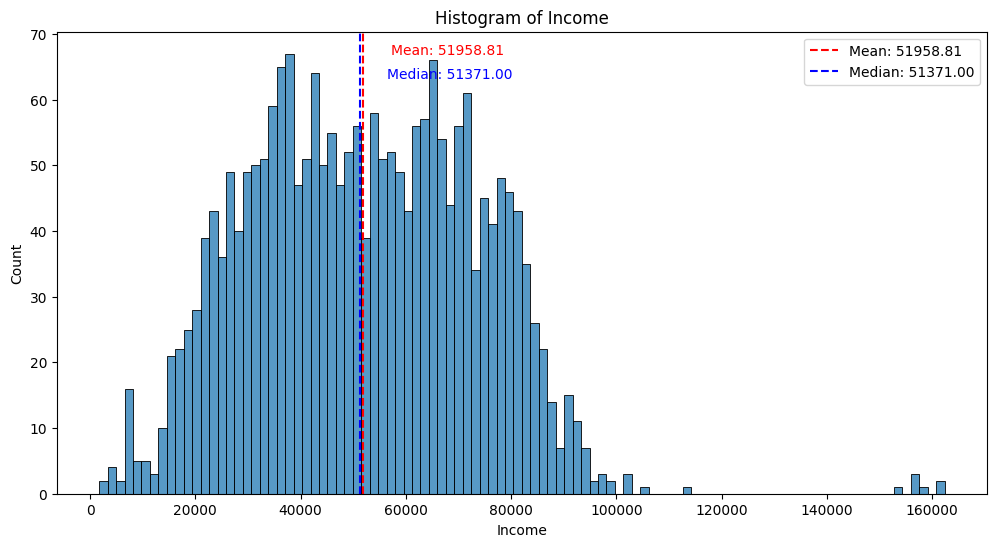

In [15]:
hist_with_vline('Income')

In [16]:
# The customers earn more than 120k are probably outliers, we will remove them.
market = market[market['Income']<120000]

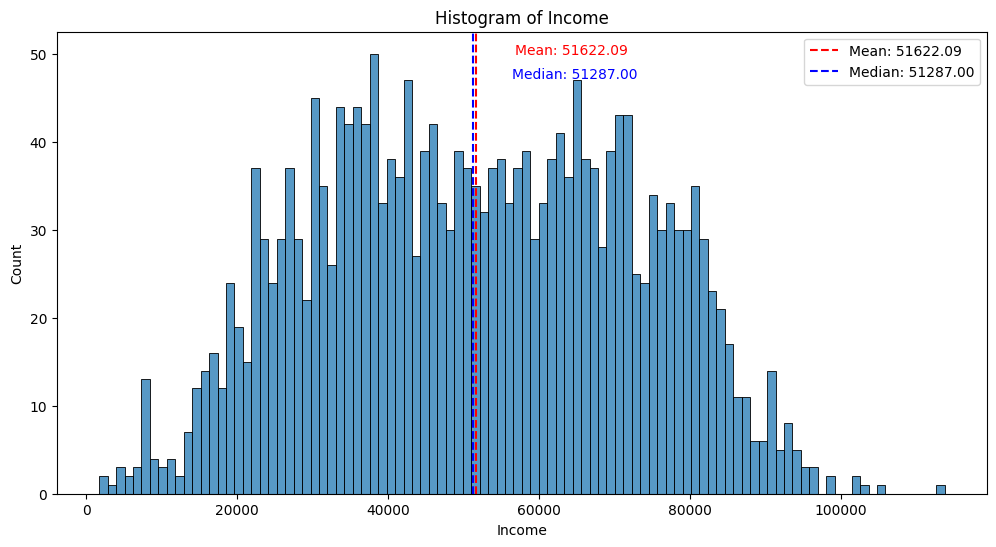

In [17]:
# Most of the customers earn between 40k to 70k.
hist_with_vline('Income')

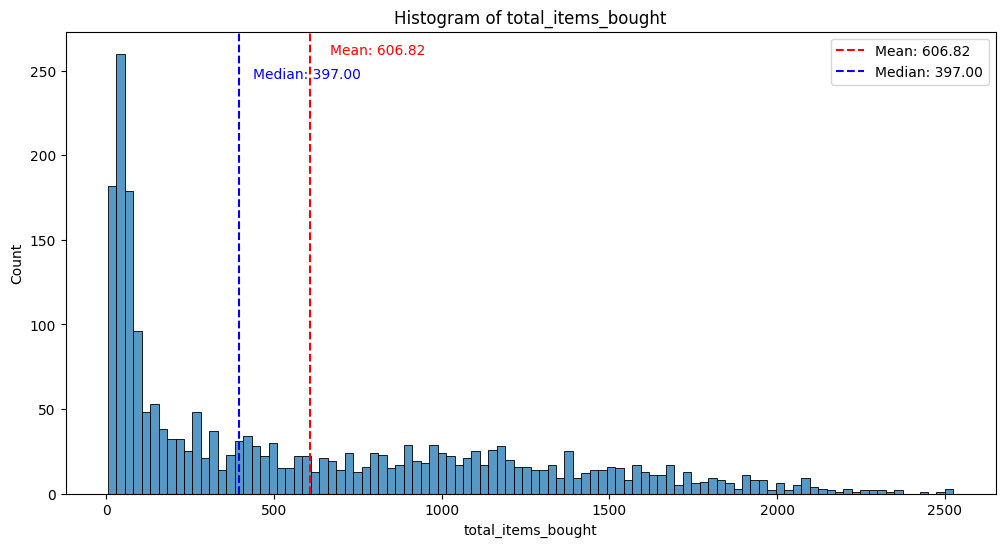

In [18]:
hist_with_vline('total_items_bought')

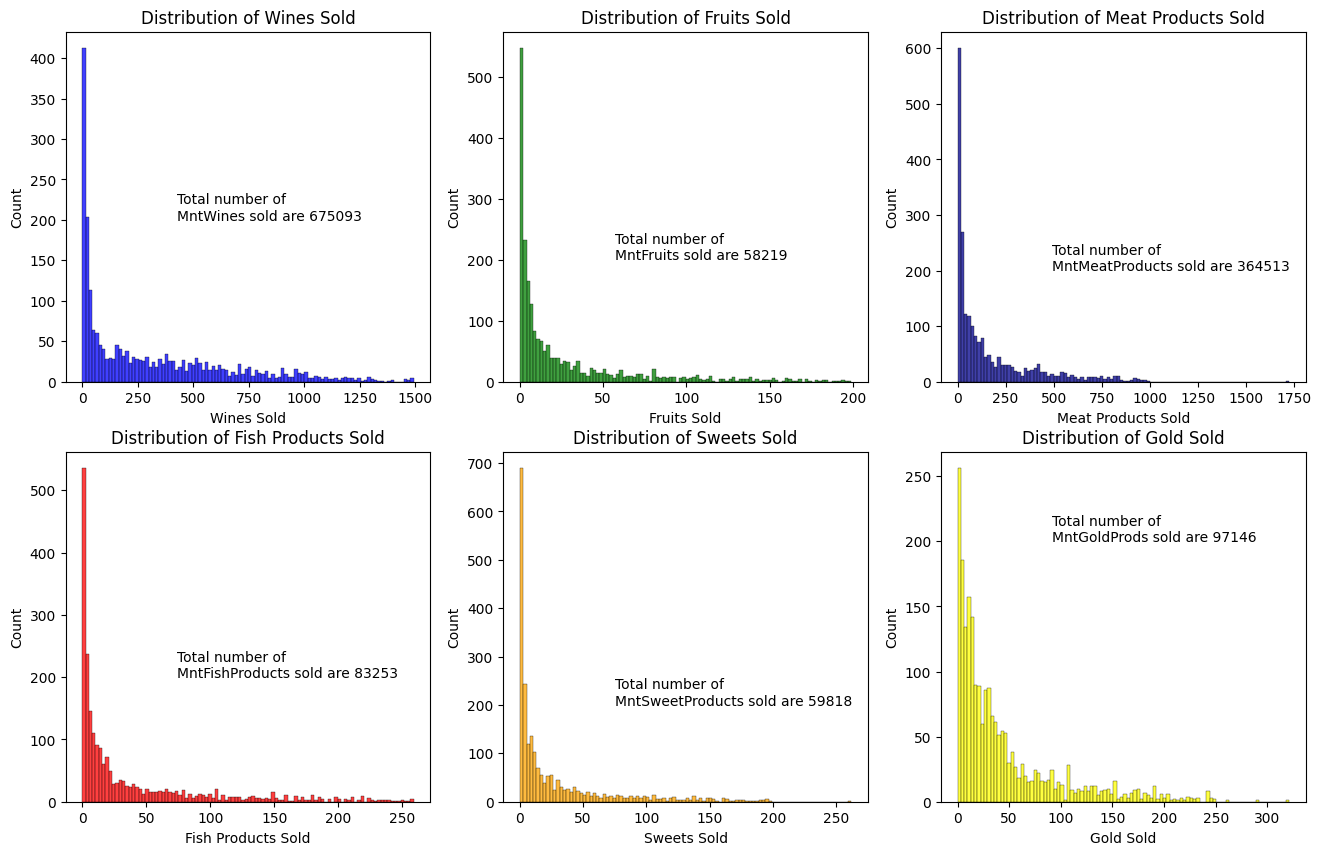

In [19]:
columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
titles = ['Wines Sold', 'Fruits Sold', 'Meat Products Sold', 'Fish Products Sold', 'Sweets Sold', 'Gold Sold']
colors = ['blue', 'green', 'darkblue', 'red', 'orange', 'yellow']

fig, ax = plt.subplots(2, 3, figsize=(16, 10))
# All the sold products histograms are right skewed. Majority of the customers buys items lower than certain amounts.
# On the other hand, Wines are the most sold items (675k) and Meat produces follow with 364k, while the Fruit and Sweet products are the least sold items (58k and 59k respectively).
for i in range(len(columns)):
    sns.histplot(market[columns[i]], bins=100, ax=ax[i // 3, i % 3], color=colors[i])
    ax[i // 3, i % 3].set_title('Distribution of ' + titles[i])
    ax[i // 3, i % 3].set_xlabel(titles[i])
    ax[i // 3, i % 3].text(s=f"Total number of \n{columns[i]} sold are {market[columns[i]].sum()} ",
                           x=market[columns[i]].max() / 3.5, y=200)

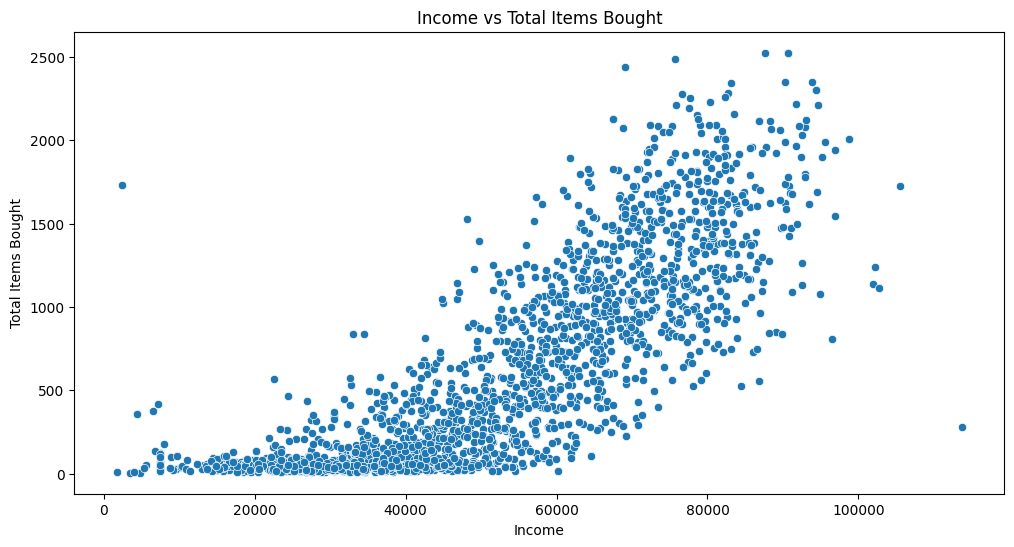

In [20]:
plt.figure(figsize=(12, 6))
# There is a linear relation with income and number of items bought.
_ = sns.scatterplot(x='Income', y='total_items_bought', data=market)
_ = plt.title('Income vs Total Items Bought')
_ = plt.ylabel('Total Items Bought')

In [21]:
px.scatter(market,
           x='Income',
           y='total_items_bought',
           color='Education',
           title='Income According to Educational Status', )

In [22]:
market.Education.value_counts()

Education
Graduation    1113
PhD            476
Master         364
2n Cycle       198
Basic           54
Name: count, dtype: int64

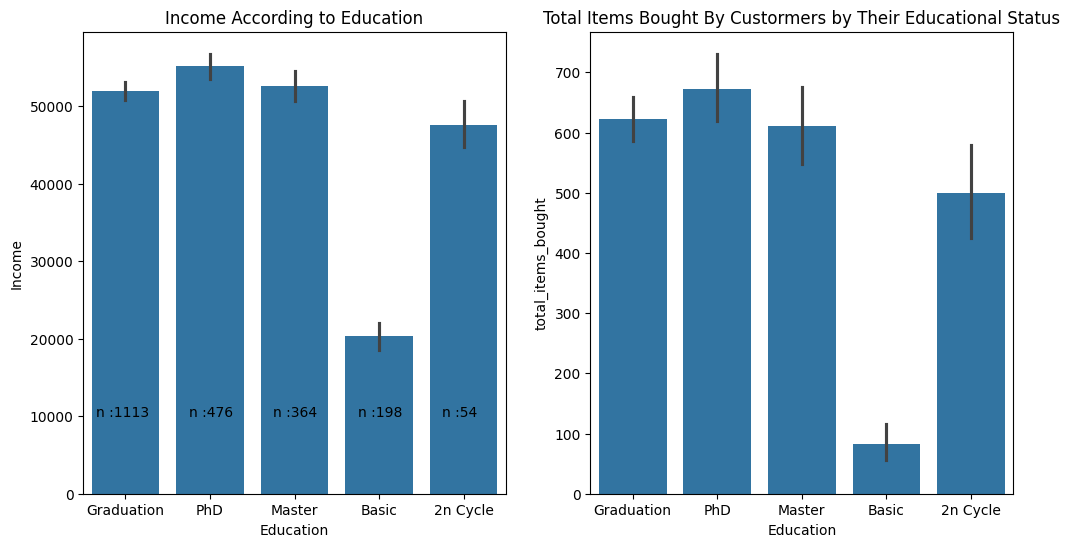

In [23]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
_ = sns.barplot(x='Education', y='Income', data=market, ax=ax0)
ax0.set_title('Income According to Education')
_ = sns.barplot(x='Education', y='total_items_bought', data=market, ax=ax1)
ax1.set_title('Total Items Bought By Custormers by Their Educational Status')
# Customers with a PhD earn and spend more than any other customers with different educational background. And, not so surprisingly Basic level educated customers earn and spend the least amount of money. And when we investigate the number of customers in each group, it is wise to investigate what customers buy with different educational backgrounds.
_ = ax0.text(s=f"n :{market.Education.value_counts()[0]}", x=-0.35, y=10000)
_ = ax0.text(s=f"n :{market.Education.value_counts()[1]}", x=0.75, y=10000)
_ = ax0.text(s=f"n :{market.Education.value_counts()[2]}", x=1.75, y=10000)
_ = ax0.text(s=f"n :{market.Education.value_counts()[3]}", x=2.75, y=10000)
_ = ax0.text(s=f"n :{market.Education.value_counts()[4]}", x=3.75, y=10000)

In [24]:
px.scatter(market,
           x='Income',
           y='total_items_bought',
           color='Marital_Status',
           title='Income According to Marital Status', )

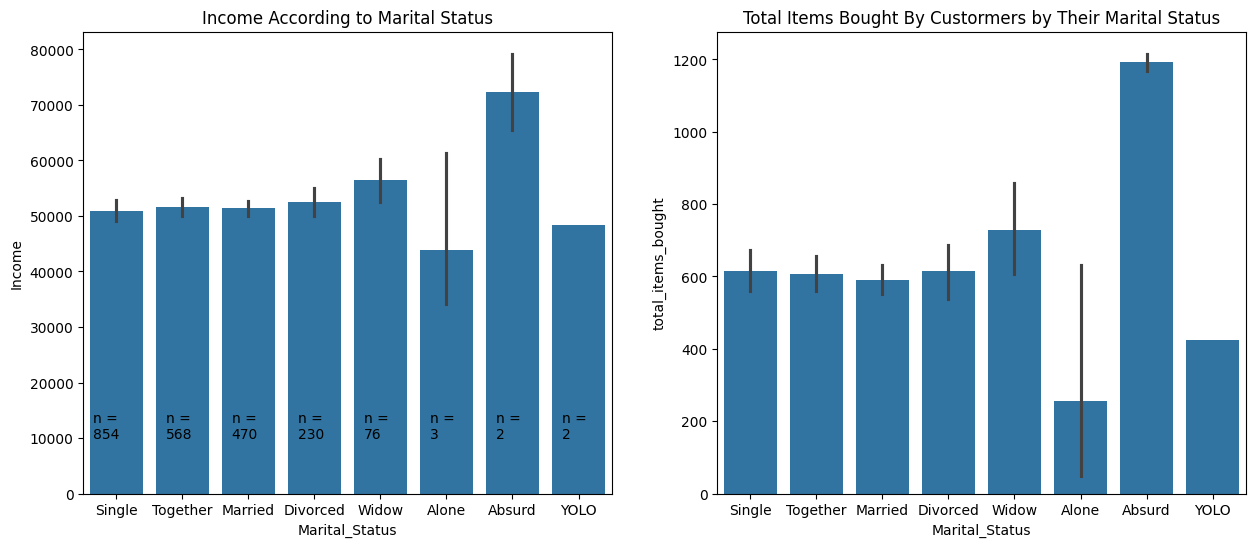

In [25]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.barplot(x='Marital_Status', y='Income', data=market, ax=ax0)
_ = ax0.set_title('Income According to Marital Status')
_ = sns.barplot(x='Marital_Status', y='total_items_bought', data=market, ax=ax1)
_ = ax1.set_title('Total Items Bought By Custormers by Their Marital Status')

# Individuals labeled as “absurd” have the highest earnings, followed by widows. However, categories like “Alone,” “absurd,” and “YOLO” might not be relevant for analysis, so it’s better to focus on the other groups and their purchasing behavior.
#

_ = ax0.text(s=f"n = \n{market.Marital_Status.value_counts()[0]}", x=-0.35, y=10000)
_ = ax0.text(s=f"n = \n{market.Marital_Status.value_counts()[1]}", x=0.75, y=10000)
_ = ax0.text(s=f"n = \n{market.Marital_Status.value_counts()[2]}", x=1.75, y=10000)
_ = ax0.text(s=f"n = \n{market.Marital_Status.value_counts()[3]}", x=2.75, y=10000)
_ = ax0.text(s=f"n = \n{market.Marital_Status.value_counts()[4]}", x=3.75, y=10000)
_ = ax0.text(s=f"n = \n{market.Marital_Status.value_counts()[5]}", x=4.75, y=10000)
_ = ax0.text(s=f"n = \n{market.Marital_Status.value_counts()[6]}", x=5.75, y=10000)
_ = ax0.text(s=f"n = \n{market.Marital_Status.value_counts()[7]}", x=6.75, y=10000)

In [26]:
# Since the number of individuals in each group varies significantly, using the total sum of purchases (e.g., Wine, Meat, etc.) wouldn’t be ideal. Instead, calculating the mean for each category would provide a clearer comparison. Let’s first examine the data using the groupby function.
market.groupby(['Education'])[market.select_dtypes(include=['number']).columns].agg(['mean', 'sum'])


Income               Kidhome       Teenhome         Recency  \
                    mean         sum      mean  sum      mean  sum       mean   
Education                                                                       
2n Cycle    47625.333333   9429816.0  0.474747   94  0.409091   81  48.383838   
Basic       20306.259259   1096538.0  0.629630   34  0.092593    5  48.444444   
Graduation  51984.008086  57858201.0  0.441150  491  0.493261  549  49.909254   
Master      52629.579670  19157167.0  0.456044  166  0.535714  195  47.346154   
PhD         55220.581933  26284997.0  0.399160  190  0.602941  287  48.500000   

                     MntWines          MntFruits        MntMeatProducts  \
              sum        mean     sum       mean    sum            mean   
Education                                                                 
2n Cycle     9580  202.757576   40146  29.626263   5866      136.378788   
Basic        2616    7.240741     391  11.111111    600       11.444444   
Graduation  55549  285.804133  318100  30.930818  34426      179.312668   
Master      17234  333.788462  121499  21.431319   7801      163.343407   
PhD         23086  409.573529  194957  20.012605   9526      163.571429   

                   MntFishProducts        MntSweetProducts         \
               sum            mean    sum             mean    sum   
Education                                                           
2n Cycle     27003       48.454545   9594        35.055556   6941   
Basic          618       17.055556    921        12.111111    654   
Graduation  199575       43.523810  48442        31.367475  34912   
Master       59457       31.574176  11493        20.865385   7595   
PhD          77860       26.897059  12803        20.411765   9716   

           MntGoldProds        NumDealsPurchases       NumWebPurchases        \
                   mean    sum              mean   sum            mean   sum   
Education                                                                      
2n Cycle      47.217172   9349          2.272727   450        3.787879   750   
Basic         22.833333   1233          1.796296    97        1.888889   102   
Graduation    50.807727  56549          2.314465  2576        4.123989  4590   
Master        40.277473  14661          2.431319   885        4.043956  1472   
PhD           32.256303  15354          2.319328  1104        4.470588  2128   

           NumCatalogPurchases       NumStorePurchases        \
                          mean   sum              mean   sum   
Education                                                      
2n Cycle              2.373737   470          5.595960  1108   
Basic                 0.481481    26          2.851852   154   
Graduation            2.719677  3027          5.854447  6516   
Master                2.552198   929          5.901099  2148   
PhD                   2.901261  1381          6.123950  2915   

           NumWebVisitsMonth       AcceptedCmp3     AcceptedCmp4      \
                        mean   sum         mean sum         mean sum   
Education                                                              
2n Cycle            5.469697  1083     0.075758  15     0.045455   9   
Basic               6.870370   371     0.111111   6     0.000000   0   
Graduation          5.292902  5891     0.070081  78     0.070979  79   
Master              5.217033  1899     0.065934  24     0.085165  31   
PhD                 5.302521  2524     0.084034  40     0.094538  45   

           AcceptedCmp5     AcceptedCmp1     AcceptedCmp2      Complain      \
                   mean sum         mean sum         mean sum      mean sum   
Education                                                                     
2n Cycle       0.050505  10     0.070707  14     0.010101   2  0.015152   3   
Basic          0.000000   0     0.000000   0     0.000000   0  0.000000   0   
Graduation     0.077269  86     0.071878  80     0.014376  16  0.012579  14   
Master    

# Analysis of Product Sales

## Education and Product Preferences
- Wine Consumption: There is a strong correlation between education level and wine purchases.
  - PhD holders buy the most wine.
  - Customers with only basic education (likely those who did not complete secondary school) purchase the least.
  - Other education levels have similar purchasing patterns (an A/B test, such as the Kruskal-Wallis test followed by the Mann-Whitney U test, could provide more insights).
- Other Products:
  - Graduates tend to buy more fruits, meat, and gold products.
  - Customers with a secondary education (2nd Cycle) purchase more fish and sweet products.

---

## Sales Channels: How Are Products Sold?
We analyze product purchases across different sales channels: deals, web, catalog, and in-store purchases.

### Purchases via Deals
- Customers with a Master’s degree frequently buy products through deals (possibly while pursuing their PhD).
- However, Graduates and PhD holders also take advantage of deals significantly.

### Online Shopping Trends
- PhD holders and Graduates use online shopping slightly more than those with a Master's degree.

### Catalog Purchases
- Again, PhD holders and Graduates are the most likely to purchase via catalogs.

### In-Store Purchases
- PhD holders seem to prefer shopping in stores the most.
- Customers with a Master’s or Graduate degree also visit physical stores frequently.

### Website Visits
- Customers with basic education levels visit the store’s website more than any other group.
- This suggests that they actively follow deals and promotions but might face challenges in completing purchases.
- A potential strategy for store owners: Introduce special deals or incentives to encourage these customers to make purchases.

Text(2.65, 50, 'Mean Sales: \n255.50')

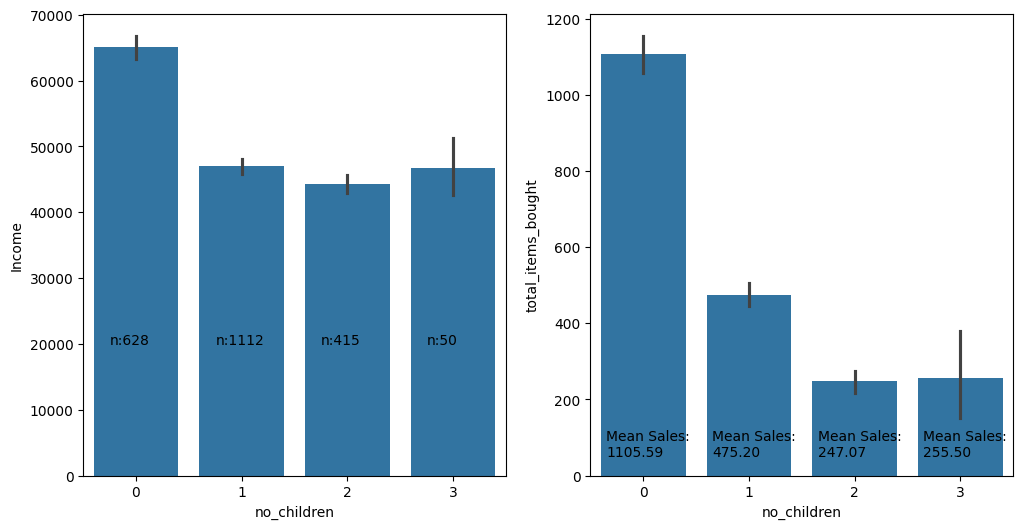

In [27]:
# Does Children effect market shopping?
# The families with no children earn and spend more than families with children.
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6), sharex=True)
_ = sns.barplot(x=market.no_children, y=market.Income, ax=ax0)
_ = sns.barplot(x=market.no_children, y=market.total_items_bought, ax=ax1)
ax0.text(s=f"n:{market[market['no_children'] == 0]['no_children'].count()}", x=-0.25, y=20000)
ax0.text(s=f"n:{market[market['no_children'] == 1]['no_children'].count()}", x=0.75, y=20000)
ax0.text(s=f"n:{market[market['no_children'] == 2]['no_children'].count()}", x=1.75, y=20000)
ax0.text(s=f"n:{market[market['no_children'] == 3]['no_children'].count()}", x=2.75, y=20000)

ax1.text(s=f"Mean Sales: \n{market[market['no_children'] == 0]['total_items_bought'].mean():.2f}", x=-0.35, y=50)
ax1.text(s=f"Mean Sales: \n{market[market['no_children'] == 1]['total_items_bought'].mean():.2f}", x=0.65, y=50)
ax1.text(s=f"Mean Sales: \n{market[market['no_children'] == 2]['total_items_bought'].mean():.2f}", x=1.65, y=50)
ax1.text(s=f"Mean Sales: \n{market[market['no_children'] == 3]['total_items_bought'].mean():.2f}", x=2.65, y=50)

In [28]:
market.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,no_children,total_items_bought,total_nbr_purchases,age
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1,0,1617,25,64
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0,2,27,6,67
2,Graduation,Together,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0,0,776,21,56
3,Graduation,Together,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0,1,53,8,37
4,PhD,Married,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0,1,422,19,40


# KMeans

In [33]:
import numpy as np
exclude_cols = [
    'Education',
    'Marital_Status',
    'AcceptedCmp3',
    'AcceptedCmp4',
    'AcceptedCmp5',
    'AcceptedCmp1',
    'AcceptedCmp2',
    'Complain',
    'Z_CostContact',
    'Z_Revenue',
    'Response'
]
X = market.drop(exclude_cols, axis=1).values
indices = np.random.choice(X.shape[0], 4, replace=False)
centers = X[indices]
print(centers.shape)
distances = np.linalg.norm(X[:, np.newaxis] - centers, axis=2)
print(distances.shape)
# print(distances)

(4, 19)
(2205, 4)


In [34]:
labels = np.argmin(distances, axis=1)
labels

array([0, 0, 0, ..., 0, 0, 0], shape=(2205,))

In [35]:
for k in range(4):
    indices = np.where(labels == k)
    print(len(indices[0]))
    mean = np.mean(X[indices], axis=1)
    print(mean.shape)
    break

1461
(1461,)


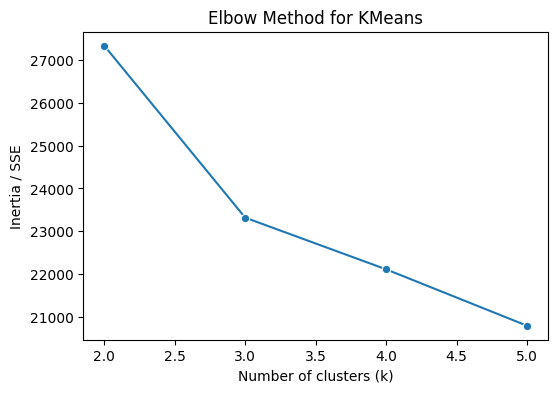

In [36]:
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


##################################################
# StandardScaler class
##################################################
class StandardScaler:
    def __init__(self):
        self.mean_ = None
        self.std_ = None

    def fit(self, X):
        """
        Calculate the mean and standard deviation for each column.

        Parameters:
            X: numpy array or DataFrame, shape (n_samples, n_features)
        """
        # If the input is a Pandas DataFrame, convert it to a numpy array
        # Prevent division by zero for features with zero standard deviation
        # 2 Points
        # TODO ===== YOUR CODE HERE =====
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        self.mean_ = X.mean(axis=0)
        self.std_ = X.std(axis=0)
        
        self.std_ = np.where(self.std_ == 0, 1e-8, self.std_)
        # TODO ==========================
        return self

    def transform(self, X):
        """
        Standardize the data using the computed mean and standard deviation.

        Parameters:
            X: numpy array or DataFrame

        Returns:
            Standardized numpy array
        """
        if isinstance(X, pd.DataFrame):
            X = X.values
        # 2 Points
        # TODO ===== YOUR CODE HERE =====
        return (X - self.mean_) / self.std_
        # TODO ==========================

    def fit_transform(self, X):
        """
        Fit to the data, then transform it.
        """
        self.fit(X)
        return self.transform(X)


##################################################
# KMeans class
##################################################
class KMeans:
    def __init__(self, n_clusters=8, max_iter=300, tol=1e-4, random_state=None):
        """
        Parameters:
            n_clusters: Number of clusters.
            max_iter: Maximum number of iterations.
            tol: Convergence threshold based on center movement.
            random_state: Random seed.
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.cluster_centers_ = None
        self.labels_ = None
        self.inertia_ = None  # Sum of Squared Errors (SSE)

    def _initialize_centers(self, X):
        """
        Randomly select (use random_state) n_clusters samples as the initial cluster centers.
        """
        np.random.seed(self.random_state)
        indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[indices]

    def fit(self, X):
        """
        Train the KMeans model.

        Parameters:
            X: numpy array or DataFrame, shape (n_samples, n_features)
        """
        if isinstance(X, pd.DataFrame):
            X = X.values
        n_samples, n_features = X.shape

        # 1. Initialize centers
        # 2 Points
        # TODO ===== YOUR CODE HERE =====
        centers = self._initialize_centers(X)
        # TODO ==========================
        
        for i in range(self.max_iter):
            # 2. Assign each sample to the nearest center (using Euclidean distance)
            distances = np.linalg.norm(X[:, np.newaxis] - centers, axis=2)  # shape: (n_samples, n_clusters)
            labels = np.argmin(distances, axis=1)
            
            # 3. Update each cluster center
            new_centers = np.zeros((self.n_clusters, n_features))
            for k in range(self.n_clusters):
                # If there are samples in cluster k, compute the mean; otherwise, randomly reinitialize the center
                # 2 Points
                # TODO ===== YOUR CODE HERE =====
                indices = np.where(labels == k)[0]
                if len(indices) > 0:
                    new_centers[k] = np.mean(X[indices], axis=0)
                else:
                    new_centers[k] = X[np.random.choice(X.shape[0], 1)]
                # TODO ==========================

            # 4. Check for convergence: stop if all centers move less than tol
            # 2 Points
            # TODO ===== YOUR CODE HERE =====
            if np.allclose(centers, new_centers, atol=self.tol):
                break
            centers = new_centers
            # TODO ==========================

        # 5. Final assignment and computation of Sum of Squared Errors (SSE)
        
        distances = np.linalg.norm(X[:, np.newaxis] - centers, axis=2)
        labels = np.argmin(distances, axis=1)
        inertia = np.sum((X - centers[labels]) ** 2)

        self.cluster_centers_ = centers
        self.labels_ = labels
        self.inertia_ = inertia

        return self
    # You actually won't use this method in this assignment, but once a K-Means algorithm has been finalized, it can be used for the new data.
    def predict(self, X):
        """
        Predict the cluster labels for new data using Euclidean Distance.

        Parameters:
            X: numpy array or DataFrame, shape (n_samples, n_features)

        Returns:
            Array of cluster labels
        """
        if isinstance(X, pd.DataFrame):
            X = X.values
        # 2 Points
        # TODO ===== YOUR CODE HERE =====
        distances = np.linalg.norm(X[:, np.newaxis] - self.cluster_centers_, axis=2)
        labels = np.argmin(distances, axis=1)
        # TODO ==========================
        return labels

    def fit_predict(self, X):
        """
        Fit the data and return the cluster labels.
        """
        self.fit(X)
        return self.labels_



# List columns to exclude (all non-numeric columns)
exclude_cols = [
    'Education',
    'Marital_Status',
    'AcceptedCmp3',
    'AcceptedCmp4',
    'AcceptedCmp5',
    'AcceptedCmp1',
    'AcceptedCmp2',
    'Complain',
    'Z_CostContact',
    'Z_Revenue',
    'Response'
]

# Exclude these columns from 'market' and copy the result to df_kmeans.
# Assume that 'market' is a preloaded DataFrame. Load data if necessary.
df_kmeans = market.drop(columns=exclude_cols, axis=1).copy()

# Standardize the numeric columns (including the recently encoded ones)
scaler = StandardScaler()
df_kmeans_scaled = scaler.fit_transform(df_kmeans)

# Use the Elbow Method to select the appropriate number of clusters (k)
cost_kmeans = []
K_range = range(2, 6)
# 2 Points
# TODO ===== YOUR CODE HERE =====
for k in K_range:
    model = KMeans(n_clusters=k)
    model.fit(df_kmeans_scaled)
    cost_kmeans.append(model.inertia_)
# TODO ==========================

# Plot the elbow curve
plt.figure(figsize=(6, 4))
sns.lineplot(x=list(K_range), y=cost_kmeans, marker='o')
plt.title('Elbow Method for KMeans')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia / SSE')
plt.show()

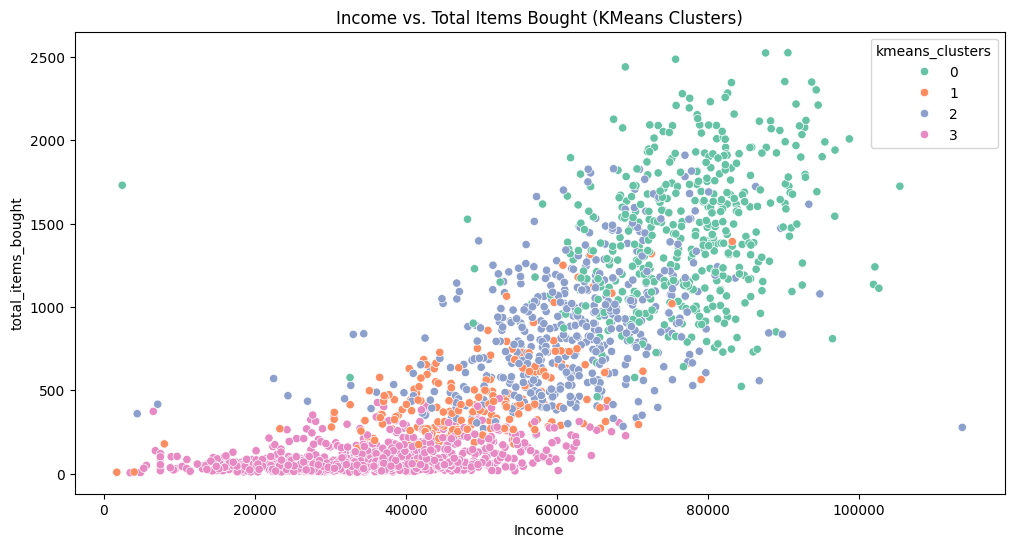

In [37]:
# Choose the appropriate number of clusters and perform the final clustering
# 2 Points
# TODO ===== YOUR CODE HERE =====
k_final = 4
# TODO ==========================
kmeans_final = KMeans(n_clusters=k_final, random_state=0)
clusters_kmeans = kmeans_final.fit_predict(df_kmeans_scaled)

# Add the new cluster labels back to the original DataFrame
market['kmeans_clusters'] = clusters_kmeans

# Visualization (example: Income vs total_items_bought)
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='Income',
    y='total_items_bought',
    data=market,
    hue='kmeans_clusters',
    palette='Set2'
)
plt.title('Income vs. Total Items Bought (KMeans Clusters)')
plt.show()

In [38]:

# View statistical descriptions for each cluster (numeric columns)
cluster_stats_kmeans = (
    market
    .groupby('kmeans_clusters')[market.select_dtypes('number').columns]
    .agg(['mean', 'sum'])
)
print(cluster_stats_kmeans)



                       Income               Kidhome       Teenhome       \
                         mean         sum      mean  sum      mean  sum   
kmeans_clusters                                                           
0                76925.800407  37770568.0  0.024440   12  0.093686   46   
1                49458.365639  11227049.0  0.788546  179  0.920705  209   
2                61614.723197  31608353.0  0.068226   35  0.859649  441   
3                34107.545175  33220749.0  0.768994  749  0.432238  421   

                   Recency           MntWines          MntFruits         \
                      mean    sum        mean     sum       mean    sum   
kmeans_clusters                                                           
0                49.608961  24358  626.890020  307803  68.830957  33796   
1                46.629956  10585  277.110132   62904  11.528634   2617   
2                49.191033  25235  522.530214  268058  33.200780  17032   
3                49.1652

In [39]:
##################################################
# Compute Sum of Squared Errors (SSE) and Silhouette Coefficient
##################################################

# Print the final Sum of Squared Errors (SSE) saved in our custom KMeans model
print("Final SSE (Inertia):", kmeans_final.inertia_)

# Compute the Silhouette Coefficient
# Note: Silhouette score is based on sample distances, so interpret cautiously for high-dimensional data
silhouette_coef = silhouette_score(df_kmeans_scaled, clusters_kmeans)
print("Silhouette Coefficient:", silhouette_coef)

Final SSE (Inertia): 22077.47117057025
Silhouette Coefficient: 0.21598673848524946


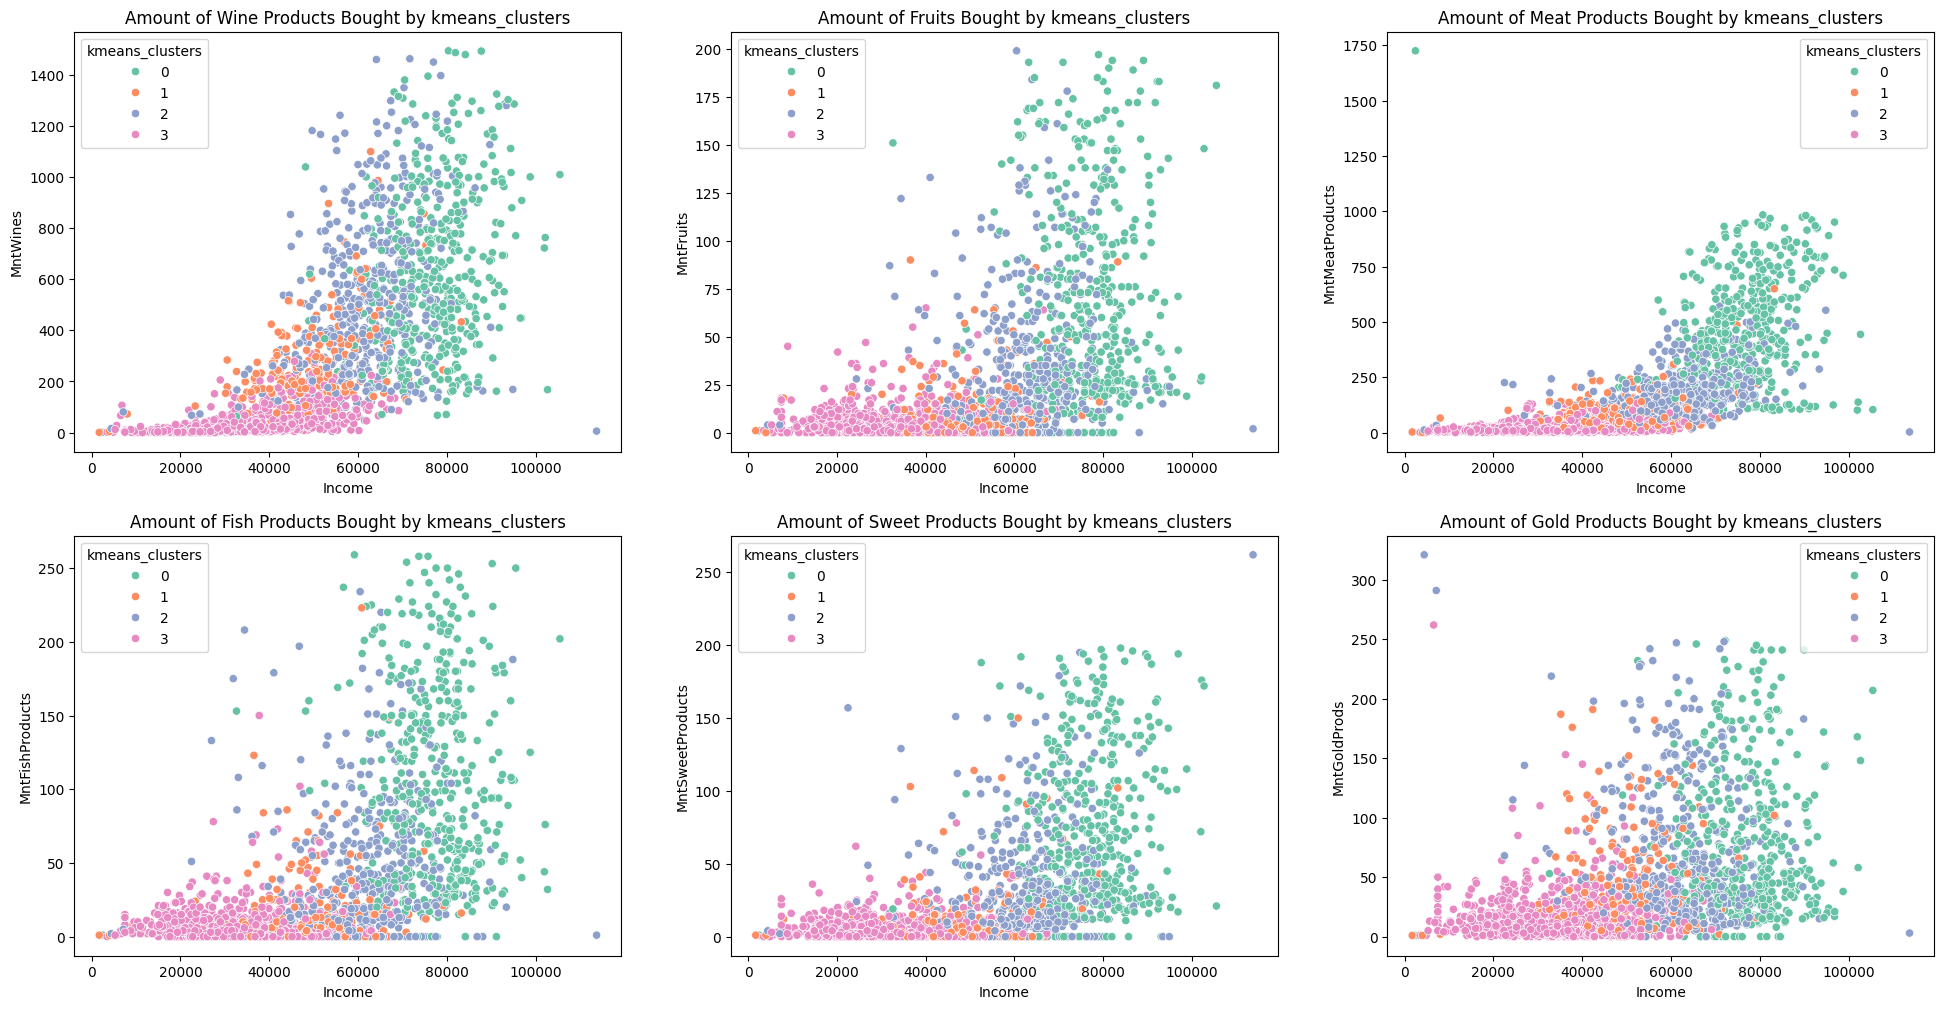

In [40]:

fig, ax = plt.subplots(2, 3, figsize=(24, 12))
_ = sns.scatterplot(x='Income', y='MntWines', data=market, hue='kmeans_clusters', palette='Set2', ax=ax[0, 0])
_ = sns.scatterplot(x='Income', y='MntFruits', data=market, hue='kmeans_clusters', palette='Set2', ax=ax[0, 1])
_ = sns.scatterplot(x='Income', y='MntMeatProducts', data=market, hue='kmeans_clusters', palette='Set2', ax=ax[0, 2])
_ = sns.scatterplot(x='Income', y='MntFishProducts', data=market, hue='kmeans_clusters', palette='Set2', ax=ax[1, 0])
_ = sns.scatterplot(x='Income', y='MntSweetProducts', data=market, hue='kmeans_clusters', palette='Set2', ax=ax[1, 1])
_ = sns.scatterplot(x='Income', y='MntGoldProds', data=market, hue='kmeans_clusters', palette='Set2', ax=ax[1, 2])

_ = ax[0, 0].set_title('Amount of Wine Products Bought by kmeans_clusters')
_ = ax[0, 1].set_title('Amount of Fruits Bought by kmeans_clusters')
_ = ax[0, 2].set_title('Amount of Meat Products Bought by kmeans_clusters')
_ = ax[1, 0].set_title('Amount of Fish Products Bought by kmeans_clusters')
_ = ax[1, 1].set_title('Amount of Sweet Products Bought by kmeans_clusters')
_ = ax[1, 2].set_title('Amount of Gold Products Bought by kmeans_clusters')

# K-Prototype

In [41]:
ss = StandardScaler()
ss_market = market.copy()

# Select all numeric columns first
numeric_cols = ss_market.select_dtypes(include='number').columns

# Then filter out the columns to exclude (even if they are numeric, they are treated as categorical and not used for scaling)
cols_to_scale = [col for col in numeric_cols if col not in exclude_cols]

# Standardize the selected columns
ss_market[cols_to_scale] = ss.fit_transform(ss_market[cols_to_scale])

In [42]:
# getting categorical columns and their indices.
catColumnsPos = [ss_market.columns.get_loc(col) for col in exclude_cols if col in ss_market.columns]
print('Categorical columns           : {}'.format(exclude_cols))


Categorical columns           : ['Education', 'Marital_Status', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']


In [43]:
print('Categorical columns position  : {}'.format(catColumnsPos))

Categorical columns position  : [0, 1, 17, 18, 19, 20, 21, 22, 23, 24, 25]


In [44]:
dfMatrix = ss_market.to_numpy()

In [45]:
cost = []
for x in range(2, 6):
    kprototype = KPrototypes(n_jobs=-1, n_clusters=x, init='Huang', random_state=0)
    clusters_kprototype = kprototype.fit_predict(dfMatrix, categorical=catColumnsPos)
    cost.append(kprototype.cost_)
    print('kprototye_clusters initiation: {}'.format(clusters_kprototype))

kprototye_clusters initiation: [1 0 1 ... 1 1 0]
kprototye_clusters initiation: [2 0 1 ... 1 1 0]
kprototye_clusters initiation: [0 2 3 ... 3 3 2]
kprototye_clusters initiation: [1 3 4 ... 4 4 3]


In [46]:
# Converting the results into a dataframe and plotting them
df_cost = pd.DataFrame()
df_cost['kprototye_clusters'] = range(2, 6)
df_cost['cost'] = cost

<Axes: xlabel='kprototye_clusters', ylabel='cost'>

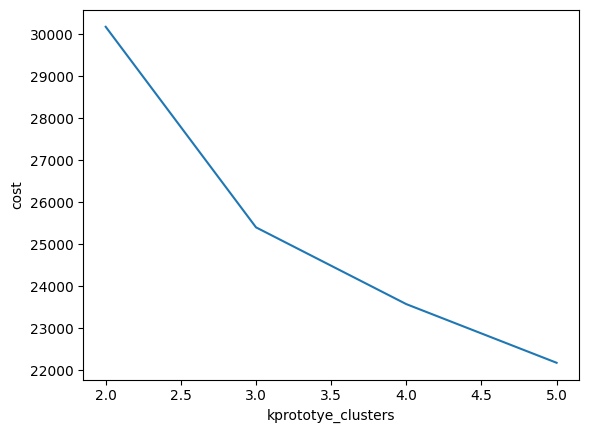

In [47]:
# elbow method for number of clusters
sns.lineplot(x='kprototye_clusters', y='cost', data=df_cost)

In [48]:
# Kmeans tuned, choose the appropriate number of clusters and perform the final clustering
# 2 Points
# TODO ===== YOUR CODE HERE =====
kprototype = KPrototypes(n_jobs=-1, n_clusters=4, init='Huang', random_state=0)
# TODO ==========================
clusters_kprototype = kprototype.fit_predict(dfMatrix, categorical=catColumnsPos)

In [49]:
market['kprototye_clusters'] = clusters_kprototype

Final SSE (numeric columns only): 21847.428557487325
Silhouette Coefficient: 0.1862085970606431


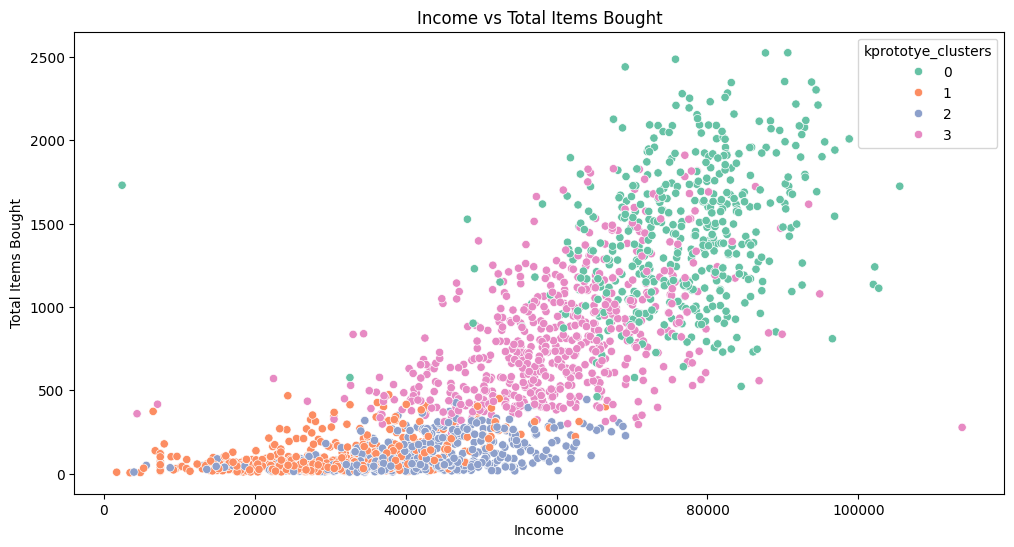

In [50]:
plt.figure(figsize=(12, 6))

# Create a scatter plot for Income vs. Total Items Bought with clusters labeled by 'kprototye_clusters'
_ = sns.scatterplot(
    x='Income',
    y='total_items_bought',
    data=market,
    hue='kprototye_clusters',
    palette='Set2'
)
_ = plt.title('Income vs Total Items Bought')
_ = plt.ylabel('Total Items Bought')

def compute_sse(df_numeric, clusters):
    """
    Compute the Sum of Squared Errors (SSE) for clusters using only numeric data. Mimic the process for K-Means

    Parameters:
        df_numeric (numpy.ndarray): 2D array containing numeric data.
        clusters (numpy.ndarray): Array of cluster labels corresponding to the rows of df_numeric.

    Returns:
        float: The total SSE across all clusters.
    """
    sse = 0.0
    unique_clusters = np.unique(clusters)
    # 2 Points
    # TODO ===== YOUR CODE HERE =====
    for cluster in unique_clusters:
        points = df_numeric[clusters == cluster]
        centroid = np.mean(points, axis=0)
        sse += np.sum((points - centroid) ** 2)
    # TODO ==========================
    return sse

##################################################
# Compute Within-Cluster SSE and Silhouette Coefficient
##################################################

# 1. Get the indices of numeric columns by excluding all categorical column positions
numeric_indices = [i for i in range(dfMatrix.shape[1]) if i not in catColumnsPos]

# 2. Extract the numeric data from dfMatrix
df_numeric = dfMatrix[:, numeric_indices]

# 3. Compute the SSE for each cluster using the defined function
sse_kprototype = compute_sse(df_numeric, clusters_kprototype)
print("Final SSE (numeric columns only):", sse_kprototype)

# 4. Compute the Silhouette Coefficient
# Note: The Silhouette score relies on pairwise distances between samples, so caution is needed when interpreting
# results for high-dimensional data.
silhouette_coef_kprototype = silhouette_score(df_kmeans_scaled, clusters_kprototype)
print("Silhouette Coefficient:", silhouette_coef_kprototype)

In [51]:
# Now our clusters are set, we need to visualize and get descriptive of the data according to clusters.
# However, from what I got we can conclude that; there are 4 clusters of the customers.
# Regular (cluster2), Bronze (cluster 1), Premium (cluster 0),and Gold Customers (cluster 3) (couldn't come up with a better idea)
# Let's see specifications of these clusters:
market.groupby(['kprototye_clusters'])[market.select_dtypes(include=['number']).columns].agg(['mean', 'sum'])


Income               Kidhome       Teenhome       \
                            mean         sum      mean  sum      mean  sum   
kprototye_clusters                                                           
0                   76925.800407  37770568.0  0.024440   12  0.093686   46   
1                   29448.917384  17109821.0  0.802065  466  0.005164    3   
2                   41772.369610  20343144.0  0.757700  369  1.043121  508   
3                   59757.253870  38603186.0  0.198142  128  0.866873  560   

                      Recency           MntWines          MntFruits         \
                         mean    sum        mean     sum       mean    sum   
kprototye_clusters                                                           
0                   49.608961  24358  626.890020  307803  68.830957  33796   
1                   48.802065  28354   32.552496   18913   6.523236   3790   
2                   49.993840  24347   67.065708   32661   3.433265   1672   
3                   47.996904  31006  488.724458  315716  29.351393  18961   

                   MntMeatProducts         MntFishProducts         \
                              mean     sum            mean    sum   
kprototye_clusters                                                  
0                       484.362525  237822      103.987780  51058   
1                        25.175559   14627        9.662651   5614   
2                        23.905544   11642        4.813142   2344   
3                       155.452012  100422       37.518576  24237   

                   MntSweetProducts        MntGoldProds         \
                               mean    sum         mean    sum   
kprototye_clusters                                               
0                         72.101833  35402    76.657841  37639   
1                          6.542169   3801    17.425129  10124   
2                          3.613963   1760    14.041068   6838   
3                         29.187307  18855    65.859133  42545   

                   NumDealsPurchases       NumWebPurchases        \
                                mean   sum            mean   sum   
kprototye_clusters                                                 
0                           1.114053   547        4.936864  2424   
1                           1.807229  1050        2.179002  1266   
2                           2.525667  1230        2.273101  1107   
3                           3.537152  2285        6.571207  4245   

                   NumCatalogPurchases       NumStorePurchases        \
                                  mean   sum              mean   sum   
kprototye_clusters                                                     
0                             6.160896  3025          8.342159  4096   
1                             0.519793   302          3.141136  1825   
2                             0.691992   337          3.511294  1710   
3                             3.357585  2169          8.065015  5210   

                   NumWebVisitsMonth       AcceptedCmp3     AcceptedCmp4      \
                                mean   sum         mean sum         mean sum   
kprototye_clusters                                                             
0                           2.590631  1272     0.081466  40     0.120163  59   
1                           6.853701  3982     0.086059  50     0.005164   3   
2                           6.006160  2925     0.055441  27     0.028747  14   
3                           5.555728  3589     0.071207  46     0.136223  88   

                   AcceptedCmp5      AcceptedCmp1      AcceptedCmp2      \
                           mean  sum         mean  sum         mean sum   
kprototye_clusters                                                        
0                      0.279022  137     0.228106  112     0.032587  16   
1                      0.000000    0     0.001721    1     0.000000   0   
2                      0.000000    0     0.004107    2     0.004107

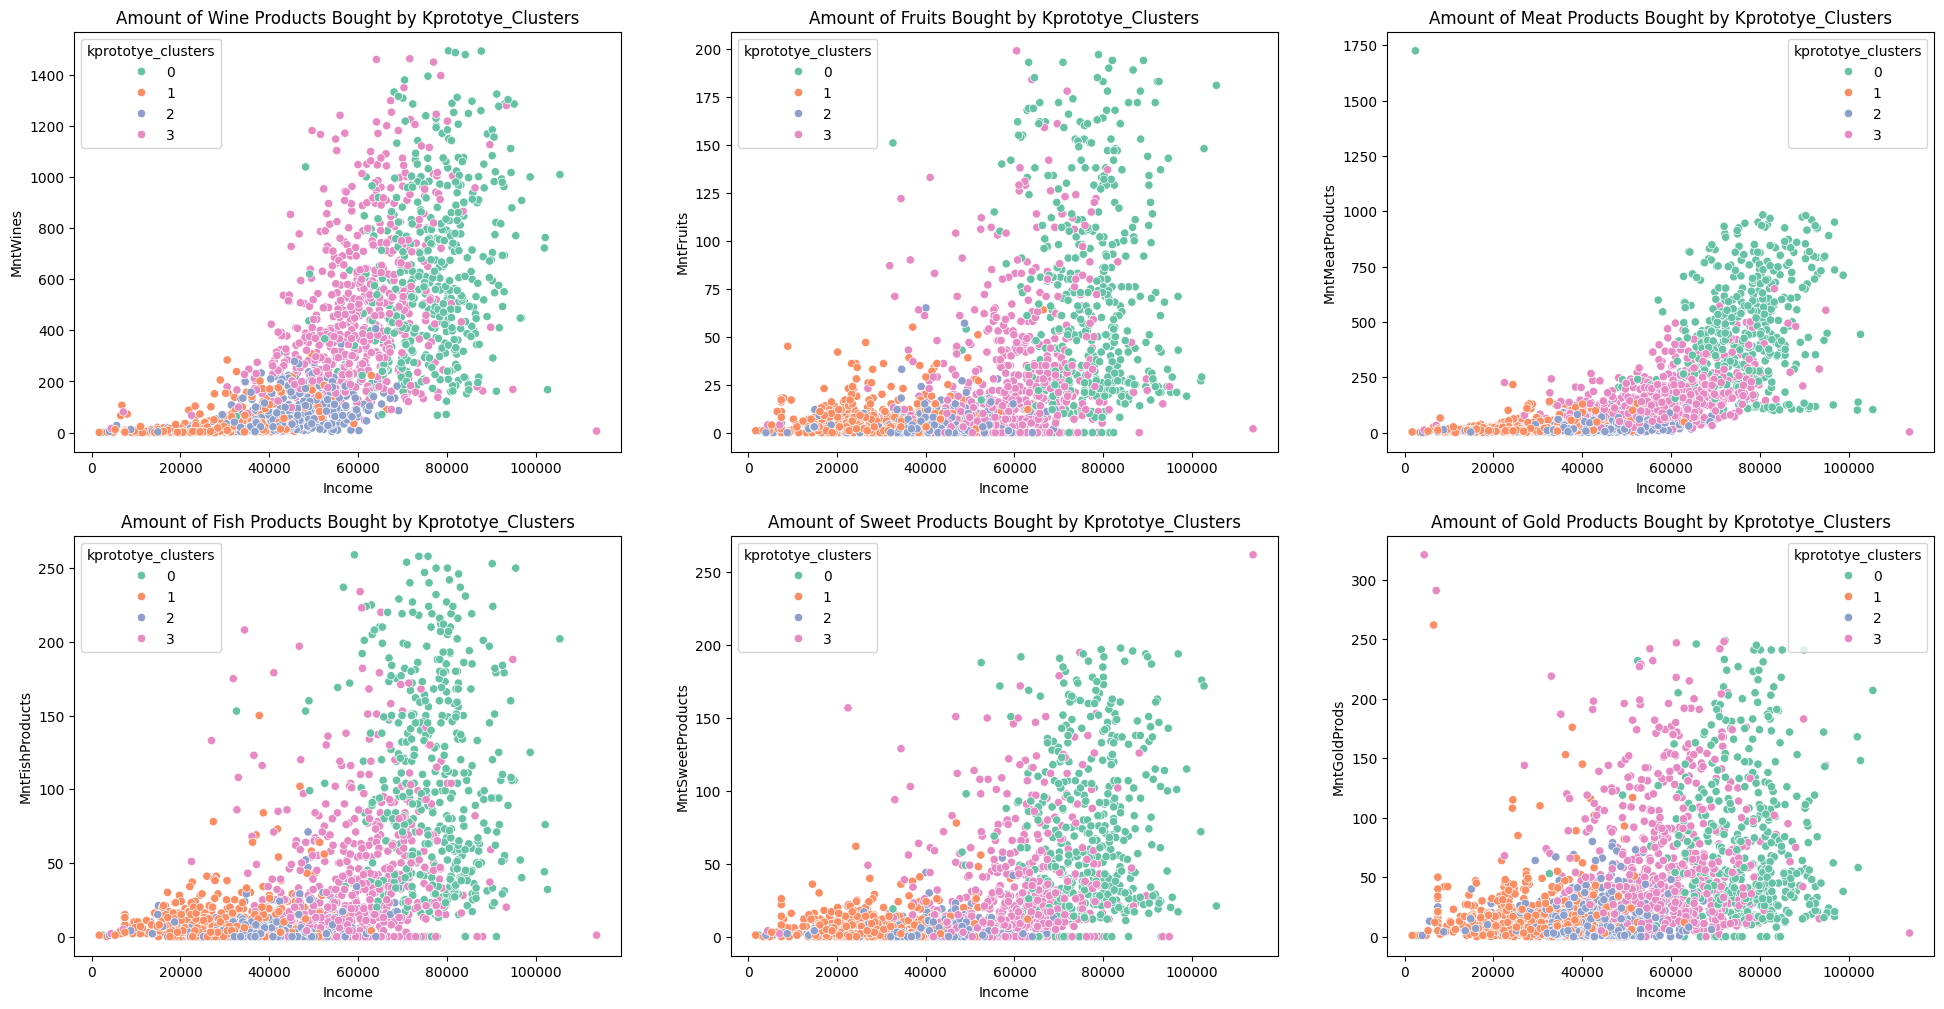

In [52]:
fig, ax = plt.subplots(2, 3, figsize=(24, 12))
_ = sns.scatterplot(x='Income', y='MntWines', data=market, hue='kprototye_clusters', palette='Set2', ax=ax[0, 0])
_ = sns.scatterplot(x='Income', y='MntFruits', data=market, hue='kprototye_clusters', palette='Set2', ax=ax[0, 1])
_ = sns.scatterplot(x='Income', y='MntMeatProducts', data=market, hue='kprototye_clusters', palette='Set2', ax=ax[0, 2])
_ = sns.scatterplot(x='Income', y='MntFishProducts', data=market, hue='kprototye_clusters', palette='Set2', ax=ax[1, 0])
_ = sns.scatterplot(x='Income', y='MntSweetProducts', data=market, hue='kprototye_clusters', palette='Set2',
                    ax=ax[1, 1])
_ = sns.scatterplot(x='Income', y='MntGoldProds', data=market, hue='kprototye_clusters', palette='Set2', ax=ax[1, 2])

_ = ax[0, 0].set_title('Amount of Wine Products Bought by Kprototye_Clusters')
_ = ax[0, 1].set_title('Amount of Fruits Bought by Kprototye_Clusters')
_ = ax[0, 2].set_title('Amount of Meat Products Bought by Kprototye_Clusters')
_ = ax[1, 0].set_title('Amount of Fish Products Bought by Kprototye_Clusters')
_ = ax[1, 1].set_title('Amount of Sweet Products Bought by Kprototye_Clusters')
_ = ax[1, 2].set_title('Amount of Gold Products Bought by Kprototye_Clusters')

# Observations

## Scatters
- **Cluster 3 (Gold Customers)** clearly earn the highest among all clusters, even though they are not the top buyers for some items (e.g., Fruits, Gold products).
- In almost every product category, the highest buyers are Gold or Premium customers.

### Suggestions:
1. **Retain Gold and Premium Customers:**
   - Continue serving their purchasing needs with exclusive deals.
   - For example, offer special promotions such as deals on high- or moderate-quality wine paired with cheese.

2. **Attract Lower-Tier Customers (Regular and Bronze):**
   - Consider expanding the product range to include a spectrum of quality levels (low, medium, and high) so that products are accessible to everyone.
   - Alternatively, create targeted deals to attract low- to middle-income customers.

## Grouped Table - Number of Purchases
- **Cluster 1** predominantly responds to deals.
  - It is advisable to monitor their purchasing behavior closely and adjust deals as their buying patterns change.
- Bronze, Gold, and Premium customers prefer online shopping.
  - To reach these groups, consider establishing email subscriptions, Instagram accounts (if not already in place), and other digital marketing channels.
  - Ensure that current customers are informed about deals, discounts, and promotions.
- **Premium and Gold customers** also tend to purchase through catalogs.
  - Since catalog buying involves ordering via email and shipping items to customers, offering shipping deals or free shipping could be very attractive.
  - Additionally, ensure that items are delivered on time.
- In-store purchases show similar trends, so the same suggestions could be applied.

## Website Visits and Online Shopping Insights
- **Regular Customers:**
  - They visit the website frequently, yet they do not always complete purchases.
- **Premium and Gold Customers:**
  - They tend to visit the website less, likely because they know what they want and spend less time online.
- Regular customers, despite their high web traffic, are predominantly buying wine and meat products, which suggests potential for improving conversion rates for these segments.


# KNN
In this section, you will implement the kNN method using the dataset and predict the customers' education level.

Remember to also answer, in short response, the analysis section after you finish implementing kNN.

In [ ]:
from collections import Counter
class KNN:
    def __init__(self, k=5):
        """
        Parameters:
            n_neighbors: Number of nearest neighbors to consider.
        """
        self.n_neighbors = k
        self.X_train = None
        self.Y_train = None

    def fit(self, X, Y):
        """
        Store the training data.

        Parameters:y
            X: numpy array or DataFrame, shape (n_samples, n_features)
            Y: numpy array or Series, shape (n_samples,)
        """
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(Y, pd.Series):
            Y = Y.values

        self.X_train = X
        self.Y_train = Y
        return self

    def _compute_distances(self, X):
        """
        Compute the Euclidean distance between X and training samples.

        Parameters:
            X: numpy array, shape (n_samples, n_features)

        Returns:
            Distances: numpy array, shape (n_samples, n_train_samples)
        """
        # 2 Points
        # TODO ===== YOUR CODE HERE =====
        
        # TODO ==========================


    def predict(self, X):
        """
        Predict class labels for the given input.

        Parameters:
            X: numpy array or DataFrame, shape (n_samples, n_features)

        Returns:
            Predicted labels: numpy array, shape (n_samples,)
        """
        if isinstance(X, pd.DataFrame):
            X = X.values
        # 2 Points
        # TODO ===== YOUR CODE HERE =====
        
        # TODO ==========================
        return predictions

    def score(self, X, Y):
        """
        Compute accuracy of the classifier.

        Parameters:
            X: numpy array or DataFrame, shape (n_samples, n_features)
            Y: numpy array or Series, shape (n_samples,)

        Returns:
            Accuracy score (float)
        """
        if isinstance(Y, pd.Series):
            Y = Y.values

        predictions = self.predict(X)
        return np.mean(predictions == Y)

    def fit_predict(self, X, Y):
        """
        Fit the data and return predictions.
        """
        self.fit(X, Y)
        return self.predict(X)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

scal = StandardScaler()  # Using your custom StandardScaler
le = LabelEncoder()

knn_market = market.copy()

exclude_c = [
    'Education',
    'Marital_Status',
    'AcceptedCmp3',
    'AcceptedCmp4',
    'AcceptedCmp5',
    'AcceptedCmp1',
    'AcceptedCmp2',
    'Complain',
    'Z_CostContact',
    'Z_Revenue',
    'Response',
    'kprototye_clusters',
    'kmeans_clusters'
]

# Encode the target variable (Education)
knn_market['Education'] = le.fit_transform(knn_market['Education'])
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
inverse_label_mapping = {v: k for k, v in label_mapping.items()}  # Reverse mapping

# Select numeric features only (excluding categorical)
numeric_cols = knn_market.select_dtypes(include='number').columns
X = knn_market.drop(columns=exclude_c)  # Drop Education from features
Y = knn_market['Education']  # Target variable

# Remove excluded columns (categorical or unwanted numeric)
cols_to_scale = [col for col in X.columns if col not in exclude_c]

# Standardize the selected numeric columns using the custom StandardScaler
X[cols_to_scale] = scal.fit_transform(X[cols_to_scale])

# Split into train and test sets (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Display dataset shapes
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}, Y_test shape: {Y_test.shape}")


In [ ]:
# Instantiate the kNN model
# 2 Points
# TODO ===== YOUR CODE HERE =====

# TODO ==========================

# Train the model on the training data
# 2 Points
# TODO ===== YOUR CODE HERE =====

# TODO ==========================

# Compute accuracy
# 2 Points
# TODO ===== YOUR CODE HERE =====

# TODO ==========================
print(f"Prediction Accuracy: {accuracy:.4f}")


In [ ]:
from sklearn.decomposition import PCA

# Apply PCA to reduce the test set to 2D
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)  # Fit on train set
X_test_pca = pca.transform(X_test)  # Transform test set

import matplotlib.pyplot as plt
import seaborn as sns

# Create scatter plot with actual labels
plt.figure(figsize=(10, 6))
Y_test_labels = np.array([inverse_label_mapping[label] for label in Y_test])
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=Y_test_labels, palette='coolwarm', edgecolor='k')

# Labels and title
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Visualization of Testing Set with Correct Education Labels')
plt.legend(title="Education Level", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


# Analysis (2 Points)
#### In **3-4 sentences**, describe the performance of kNN in this situation and why it faces issues when encountering high dimensionality.